In [2]:
import wandb
import composuite
from diffusion.utils import *
from diffusion.elucidated_diffusion import Trainer
from diffusion.train_diffuser import SimpleDiffusionGenerator

gin.parse_config_file("/home/anhquanpham/projects/compositional-rl-synth-data/config/diffusion.gin")

base_data_path = '/home/anhquanpham/projects/data'
base_results_folder = '/home/anhquanpham/projects/results'


In [3]:
def remove_indicator_vectors(modality_dims, dataset):

    dataset = dataset.copy()

    start_index = sum([dim[0] for key, dim in modality_dims.items() if key in ['object-state', 'obstacle-state', 'goal-state']])
    end_index = start_index + sum([dim[0] for key, dim in modality_dims.items() if key in ['object_id', 'robot_id', 'obstacle_id', 'subtask_id']])

    def remove_indicator_dims(data, start, end):
        indicators_ = data[:, start:end]
        data_ = np.delete(data, np.arange(start, end), axis=1)
        return data_, indicators_

    observations, obs_indicators = remove_indicator_dims(dataset['observations'], start_index, end_index)
    dataset['observations'] = observations
    next_observations, _ = remove_indicator_dims(dataset['next_observations'], start_index, end_index)
    dataset['next_observations'] = next_observations
    
    return dataset, obs_indicators

In [4]:
dataset_type = 'expert'

robot = 'IIWA'
obj = 'Box'
obst = 'None'
task = 'PickPlace'

results_folder = os.path.join(base_results_folder, robot + '_' + obj + '_' + obst + '_' + task)



env = composuite.make(robot, obj, obst, task, use_task_id_obs=True, ignore_done=False)
dataset = load_single_composuite_dataset(base_path=base_data_path, 
                                         dataset_type=dataset_type, 
                                         robot=robot, obj=obj, 
                                         obst=obst, task=task)
dataset = transitions_dataset(dataset)

print('Before removing task indicators:', dataset['observations'].shape)
dataset, indicators = remove_indicator_vectors(env.modality_dims, dataset)
print('After removing task indicators:', dataset['observations'].shape, indicators.shape)
print(env.modality_dims)

print(dataset.keys())  # Should still contain 'observations' and 'next_observations'


inputs = make_inputs(dataset)

/home/anhquanpham/.pyenv/versions/first_3.9.6/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Before removing task indicators: (999999, 93)
After removing task indicators: (999999, 77) (999999, 16)
{'object-state': (14,), 'obstacle-state': (14,), 'goal-state': (17,), 'object_id': (4,), 'robot_id': (4,), 'obstacle_id': (4,), 'subtask_id': (4,), 'robot0_proprio-state': (32,)}
dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])


In [5]:
print(inputs[0]) # 164 = 77 + 8 + 1 + 77 + 1 #STATE + ACTION + REWARD + NEXT STATE + TERMINAL, formatted in make_inputs

[ 3.61086540e-02 -1.57110706e-01  8.50000024e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  6.70293272e-02
  5.71107194e-02  1.56766713e-01  9.99999702e-01  0.00000000e+00
  7.96326727e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.95669660e-02 -1.00000024e-01  1.00670826e+00
  9.99999702e-01  0.00000000e+00  7.96326727e-04  0.00000000e+00
  1.00000001e-01  1.80000007e-01  8.29999983e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  1.30888745e-01
 -2.80000061e-01  1.76868483e-01  9.99999702e-01  0.00000000e+00
  7.96326727e-04  0.00000000e+00  6.38913438e-02  3.37110698e-01
 -1.99999996e-02  1.00000000e+00  7.96083808e-01  1.00000000e+00
 -3.13810557e-01  1.00000000e+00  8.25335622e-01  1.00000000e+00
  0.00000000e+00  6.05186403e-01  0.00000000e+00 -9.49485600e-01
  0.00000000e+00  5.64642489e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

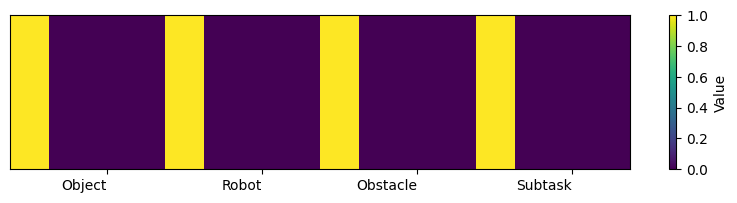

In [10]:
idx = 0
import matplotlib.pyplot as plt

task_vector = indicators[idx, :].reshape(1, -1)

labels = ['Object', 'Robot', 'Obstacle', 'Subtask']
plt.figure(figsize=(10, 2))
plt.imshow(task_vector, cmap="viridis", aspect="auto")
plt.colorbar(label="Value")
plt.xticks(ticks=[2, 6, 10, 14], labels=labels, ha='right')
plt.yticks([])
plt.show()

In [12]:
inputs = torch.from_numpy(inputs).float()
indicators = torch.from_numpy(indicators).float()
dataset = torch.utils.data.TensorDataset(inputs, indicators)

In [14]:
diffusion = construct_diffusion_model(inputs=inputs, cond_dim=16)

INPUT DIM AT RESIDUALMLP SHOULD BE 164:  164
Skipping normalization for dimensions [163].
Means: tensor([ 6.3589e-02,  1.0651e-01,  8.6088e-01, -1.6371e-02, -1.2360e-02,
         1.7438e-01,  9.5864e-01,  1.6769e-02,  9.9819e-03,  3.5345e-02,
         5.4525e-01, -3.0514e-03,  9.8454e-02,  6.1551e-02,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.6970e-01,  1.0005e-01,  7.7840e-01,  4.5343e-01,
         1.5858e-01,  8.5067e-02,  7.3912e-02,  1.0000e-01,  1.8000e-01,
         8.3000e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         2.3125e-02, -4.1920e-02,  4.6128e-02,  4.5343e-01,  1.5858e-01,
         8.5067e-02,  7.3912e-02,  3.6411e-02,  7.3486e-02, -3.0883e-02,
         9.1670e-01,  5.0138e-01,  9.8886e-01,  3.1583e-04,  9.6788e-01,
         9.6581e-01,  9.7018e-01,  2.6684e-01,  8.5701e-01,  9.7417e-02,
        -9.9253e-01, -2.0960e-01,  2.3004e-01,  1.1947e-01,  2.5523e-02,
         1.8551e-02,  2.006

In [16]:
wandb_project = 'offline_rl_diffusion'
wandb_entity = ''
wandb_group = 'diffusion_training'

wandb.init(
    project=wandb_project,
    entity=wandb_entity,
    group=wandb_group,
    name=results_folder.split('/')[-1],
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: phamanhquanbill (compositional-rl). Use `wandb login --relogin` to force relogin
/home/anhquanpham/.pyenv/versions/first_3.9.6/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:84: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [18]:
trainer = Trainer(diffusion, dataset, results_folder=results_folder)
trainer.train()

Number of trainable parameters: 25911764.
Using batch size: 1024
Using cosine learning rate scheduler with warm restarts.


  0%|          | 0/10 [00:00<?, ?it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP:  torch.Size([1024, 164])
OUTPUT DIM:  torch.Size([1024, 164])
OUTPUT DIM AT MAIN NETWORK  torch.Size([1024, 164])
In Residual MLP:  torch.Size([1024, 164])
OUTPUT DIM:  torch.Size([1024, 164])


loss: 1.0121:  10%|█         | 1/10 [00:02<00:21,  2.34s/it]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP:  torch.Size([1024, 164])
OUTPUT DIM:  torch.Size([1024, 164])
OUTPUT DIM AT MAIN NETWORK  torch.Size([1024, 164])
In Residual MLP:  torch.Size([1024, 164])
OUTPUT DIM:  torch.Size([1024, 164])


loss: 0.9951:  20%|██        | 2/10 [00:04<00:15,  1.98s/it]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP:  torch.Size([1024, 164])
OUTPUT DIM:  torch.Size([1024, 164])
OUTPUT DIM AT MAIN NETWORK  torch.Size([1024, 164])
In Residual MLP:  torch.Size([1024, 164])
OUTPUT DIM:  torch.Size([1024, 164])


loss: 0.9951:  20%|██        | 2/10 [00:04<00:19,  2.42s/it]


KeyboardInterrupt: 

In [ ]:
@gin.configurable
class SimpleDiffusionGenerator:
    def __init__(
            self,
            env: gym.Env,
            ema_model,
            num_sample_steps: int = 128,
            sample_batch_size: int = 10, #fix to 100000 before pushing
    ):
        self.env = env
        self.diffusion = ema_model
        self.diffusion.eval()
        # Clamp samples if normalizer is MinMaxNormalizer
        self.clamp_samples = isinstance(self.diffusion.normalizer, MinMaxNormalizer)
        self.num_sample_steps = num_sample_steps
        self.sample_batch_size = sample_batch_size
        print(f'Sampling using: {self.num_sample_steps} steps, {self.sample_batch_size} batch size.')

    def sample(
            self,
            num_samples: int,
            cond: None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        
        assert num_samples % self.sample_batch_size == 0, 'num_samples must be a multiple of sample_batch_size'

        if cond is not None:
            cond = torch.from_numpy(cond).float().to(self.diffusion.device)
            cond = cond.unsqueeze(0).expand(self.sample_batch_size, -1)

        num_batches = num_samples // self.sample_batch_size
        observations = []
        actions = []
        rewards = []
        next_observations = []
        terminals = []

        for i in range(num_batches):
            print(f'Generating split {i + 1} of {num_batches}.')
            sampled_outputs = self.diffusion.sample(
                batch_size=self.sample_batch_size,
                num_sample_steps=self.num_sample_steps,
                clamp=self.clamp_samples,
                cond=cond
            )
            sampled_outputs = sampled_outputs.cpu().numpy()

            # Split samples into (s, a, r, s') format
            transitions = split_diffusion_samples(sampled_outputs, self.env)
            if len(transitions) == 4:
                obs, act, rew, next_obs = transitions
                terminal = np.zeros_like(next_obs[:, 0])
            else:
                obs, act, rew, next_obs, terminal = transitions
            observations.append(obs)
            actions.append(act)
            rewards.append(rew)
            next_observations.append(next_obs)
            terminals.append(terminal)
        observations = np.concatenate(observations, axis=0)
        actions = np.concatenate(actions, axis=0)
        rewards = np.concatenate(rewards, axis=0)
        next_observations = np.concatenate(next_observations, axis=0)
        terminals = np.concatenate(terminals, axis=0)

        return observations, actions, rewards, next_observations, terminals

In [ ]:
task_indicator = get_task_indicator(robot, obj, obst, task)
env = composuite.make(robot, obj, obst, task, use_task_id_obs=False, ignore_done=False)
generator = SimpleDiffusionGenerator(env=env, ema_model=trainer.ema.ema_model)
observations, actions, rewards, next_observations, terminals = generator.sample(num_samples=10, cond=task_indicator) #Fix numsamples to 100000 before pushing

In [ ]:
np.savez_compressed(
    os.path.join(results_folder, 'samples.npz'),
    observations=observations,
    actions=actions,
    rewards=rewards,
    next_observations=next_observations,
    terminals=terminals
)